In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
%matplotlib inline

from datetime import date
from datetime import timedelta
import zipfile
import os
import requests

import numpy as np
import cv2
import math
import random 

!pip install geopy
import geopy.distance
!pip install geopandas
import geopandas  as gpd
from shapely.geometry import Point, LineString, Polygon


# Import specific function 'from_epsg' from fiona module
from fiona.crs import from_epsg

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 4.7 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 29.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 91.7 MB/s eta 0:00:00:00:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


# Damage Bucketing

In [118]:
image = cv2.imread('model7-diffdiff-results/Soufriere_St_Vincent_2020-04-05_360150_22385_dVV_dd.png', cv2.COLOR_BGR2GRAY )

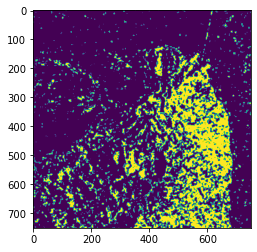

In [119]:
plt.imshow(image)

In [30]:
def bucketize_image_diff(image, kernel=50):
    image_size = image.shape[0]
    iterations = image_size / kernel
    image_len = image.shape[1]
    copy = image.copy()
    for row in range(0, image_len, kernel):
        for col in range(0, image_len, kernel):
            subset = copy[row:row+kernel, col:col+kernel]
            num_1 = (subset==1).sum()
            num_255 = (subset==255).sum()
            num_0 = (subset==0).sum()

            if num_255 >= (kernel**2)*0.3:
                copy[row:row+kernel, col:col+50] = 255
            elif num_255>=(kernel**2)*0.10 and num_1>=(kernel**2)*0.3:
                copy[row:row+kernel, col:col+50] = 255
            elif (num_255+num_1) >= (kernel**2)*0.4:
                copy[row:row+kernel, col:col+50] = 100
            else:
                copy[row:row+kernel, col:col+50] = 0
                
    return copy

In [120]:
bucketized = bucketize_image_diff(image, kernel=50)

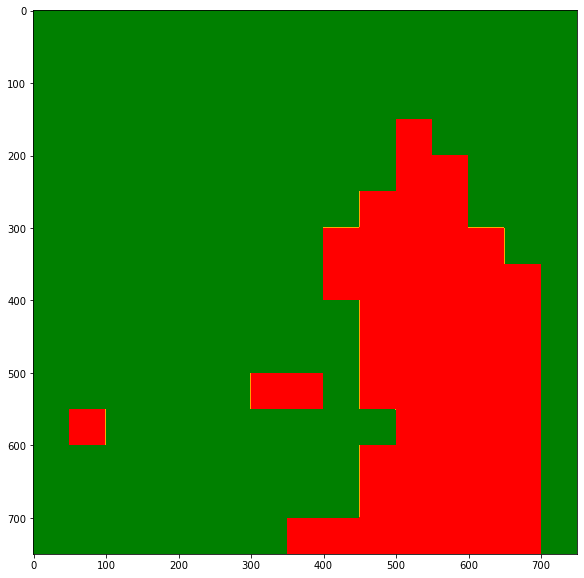

In [121]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['green','orange', 'red'])
bounds=[0,100,255]

plt.figure(figsize=(20, 10))
plt.imshow(bucketized, cmap=cmap)

# Generate Shapefile from Bucketized Damage

In [141]:
def get_meter_distance(x1, y1, x2=375, y2=375):
    '''Return hypotenuse distance in meters between two pixel centers of blocks assuming 1 pixel = 30 m'''
    a = abs(x1-x2)
    b = abs(y1-y2)
    return math.sqrt(a**2 + b**2)*30

def get_damage_type(pixel):
    if pixel == 255:
        return 'high'
    elif pixel== 1:
        return 'med'
    else:
        return 'low'
    

def get_quadrant_subtractor(x1, y1):
    '''Selecting quadrant based on image coordinates'''
    if x1>=375 and y1<=375: # first quadrant
        return 90
    elif x1>=375 and y1>=375: # second quadrant
        return 180
    elif x1<=375 and y1>=375: # third quadrant
        return 270
    else:
        return 360
    
def get_bearing(x1, y1, x2=375, y2=375):
    '''Tutorial here - https://mathsathome.com/calculating-bearings/
    Geopy radians takes degrees, so will convert to degrees at the end
    '''
    a = abs(x1-x2)
    b = abs(y1-y2)
#     print(f"x-val: {a}, y-val:{b}")
    if a==0 and y1<375:
        return 0
    elif a==0 and y1>=375:
        return 180
    angle = math.atan(b/a)

    bearing = get_quadrant_subtractor(x1, y1) - math.degrees(angle)
    return bearing

def get_lat_long(distance, bearing, lat, lon):
    '''get the latitude and longitude of the bucketed damage point center to be used as the new center to generate shapefiles
    
    distance -> distance in meters
    bearing -> bearing in degrees
    lat -> latitude of original point in degrees
    lon -> longitude of original point in degrees
    
    '''
    R = 6378.1 #Radius of the Earth
    brng = math.radians(bearing) #Bearing is 90 degrees converted to radians.
    d = distance/1000 #Distance in km

    #lat2  52.20444 - the lat result I'm hoping for
    #lon2  0.36056 - the long result I'm hoping for.

    lat1 = math.radians(lat) #Current lat point converted to radians
    lon1 = math.radians(lon) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
         math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lat2, lon2

def generate_bearings(point_bearing, k=20, increment=10):
    '''Generate a list of bearings based on the point_bearing
    k -> integer, number of bearings
    increment -> index, number of breaks in the range
    '''
    bearings = []
    weights = []
    range_len = len(range(0,360,increment))
    quarter, half, three_quarters = int(range_len/4), int(2*range_len/4), int(3*range_len/4)
    half_prob, three_quarter_prob = 0.5/quarter, 0.5/three_quarters
    if point_bearing <= 90: # first quadrant
        # 50% probability for the first quadrant
        weights = [half_prob]*quarter + [three_quarter_prob]* three_quarters
        
    elif point_bearing <=180:
        weights = [three_quarter_prob]*quarter + [half_prob]*quarter + [three_quarter_prob]*half
    elif point_bearing <= 270:
        weights= [three_quarter_prob]*half + [half_prob]*quarter + [three_quarter_prob]*quarter
    else:
        weights= [three_quarter_prob]*three_quarters + [half_prob]*quarter
    while len(bearings) <= k:
        rand_bearing = random.choices(range(0, 360, increment), weights= weights, k=1)[0]
        if rand_bearing not in bearings:
            bearings.append(rand_bearing)
    return sorted(bearings)


def get_polygon(lat, lon, point_bearing):
    pts = []
    # base the bearing on the direction the block point is from the center point
    # 50% chance for values in the same bearing area and 50% for bearings in other quadrants 
    bearings = generate_bearings(point_bearing,k=15, increment=10)
    num_bearings = 20
    for bearing in sorted(bearings):
         #calculate random meter distance to head to based on 1 to 25 pixels (block size)
        rand_dist = np.random.choice(range(100, 751, 1))
        pt =  geopy.distance.distance(meters=rand_dist)\
                    .destination((lat, lon), bearing=bearing)[:2] # go the calculated distance based on the volcano distance and bearing (angle)
        pts.append([pt[1],pt[0]])
        
    return Polygon(pts)

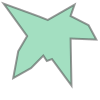

In [35]:
get_polygon(3.17, 98.392, 270)

# Full pipeline

In [57]:
targets = pd.read_csv('Sample Eruptions.csv')

In [122]:
targets.head()

,Volcano Number,Volcano Name,Eruption Number,Eruption Category,Area of Activity,VEI,VEI Modifier,Start Year Modifier,Start Date,Start Year,...,End Date,End Year,End Year Uncertainty,End Month,End Day Modifier,End Day,End Day Uncertainty,Latitude,Longitude,Reference Year
0,233020,"Fournaise, Piton de la",22343,Confirmed Eruption,NaN,0,NaN,NaN,2020-2-10,2020,...,2020-4-6,2020,NaN,4,NaN,6,NaN,-21.244,55.708,2013
1,273070,Taal,22344,Confirmed Eruption,NaN,4,NaN,NaN,2020-1-12,2020,...,2020-1-22,2020,NaN,1,NaN,22,NaN,14.002,120.993,2019
2,282050,Kuchinoerabujima,22345,Confirmed Eruption,NaN,3,NaN,NaN,2020-1-11,2020,...,2020-5-13,2020,NaN,5,NaN,13,NaN,30.443,130.217,2017
3,345020,Rincon de la Vieja,22346,Confirmed Eruption,NaN,2,NaN,NaN,2020-1-30,2020,...,2020-12-13,2020,NaN,12,NaN,13,NaN,10.830,-85.324,2013
4,353010,Fernandina,22347,Confirmed Eruption,NaN,0,NaN,NaN,2020-1-12,2020,...,2020-1-13,2020,NaN,1,NaN,13,NaN,-0.370,-91.550,2019


In [95]:
diffdiff_files[5].split('_')[-5]

'2021-03-07'

In [47]:
diffdiff_files = []
for file in os.listdir("model7-diffdiff-results/"):
    if file.endswith(".png"):
        diffdiff_files.append(file)

In [143]:
newdata = gpd.GeoDataFrame()
datarows = []
for file in diffdiff_files:
    print(file)
    layer = -1
    eruption_id = int(file.split('_')[-3])
    data = targets[targets['Eruption Number'] == eruption_id]
    vlat = data.iloc[0]['Latitude']
    vlon = data.iloc[0]['Longitude']
    v_name = data.iloc[0]['Volcano Name']
    volc_num = data.iloc[0]['Volcano Number']
    erupt_start_date = date(data.iloc[0]["Start Year"].astype(int),
                            data.iloc[0]["Start Month"].astype(int),
                            data.iloc[0]["Start Day"].astype(int))
    diffdiff_date = file.split('_')[-5]
    
    path = 'model7-diffdiff-results/'
    image = cv2.imread(path+file, cv2.COLOR_BGR2GRAY )
    bucketized_diffdiff = bucketize_image_diff(image)
    
    # Iterate through diffdiff image and append a new row for each damage center
    kernel=50
    iterations = image.shape[1] / kernel
    image_len = image.shape[1]
#     polygons = []
    for row in range(25, image_len, kernel):
        for col in range(25, image_len, kernel):
            if get_damage_type(image[row, col]) != 'low':
                if get_damage_type(image[row, col]) == 'high':
                    layer=255
                else:
                    layer = 254
                    
                meters = get_meter_distance(row, col)
                bearing = get_bearing(row, col)
                lat, lon = get_lat_long(meters, bearing, vlat, vlon)
                polygon = get_polygon(lat, lon, bearing)
                
                datarows.append([polygon, v_name, int(volc_num),int(eruption_id),erupt_start_date.isoformat(), pd.to_datetime(diffdiff_date).isoformat(), int(layer)])

    newdata = gpd.GeoDataFrame(datarows)
    newdata.columns = ['geometry', 'volc_name', 'volc_num', 'erupt_num', 'est_date', 'diffdiff_date', 'layer']
    
    

Soufriere_St_Vincent_2020-04-05_360150_22385_dVV_dd.png
Sinabung_2018-10-24_261080_22365_dVV_dd.png
Soufriere_St_Vincent_2021-03-28_360150_22385_dVV_dd.png
Kilauea_2020-02-23_332010_22380_aVH_dd.png
Rincon_de_la_Vieja_2020-03-12_345020_22346_aVH_dd.png
Kilauea_2021-03-07_332010_22380_aVH_dd.png
Rincon_de_la_Vieja_2019-03-21_345020_22346_dVV_dd.png
Fournaise_Piton_de_la_2020-04-06_233020_22343_dVV_dd.png
Soufriere_St_Vincent_2020-04-05_360150_22385_aVH_dd.png
Kilauea_2021-02-21_332010_22380_aVH_dd.png
Rincon_de_la_Vieja_2019-04-04_345020_22346_dVV_dd.png
Turrialba_2019-08-22_345070_22369_aVH_dd.png
Kilauea_2021-02-28_332010_22380_aVH_dd.png
Fournaise_Piton_de_la_2019-03-18_233020_22343_dVV_dd.png
Kilauea_2020-03-08_332010_22380_dVV_dd.png
Kilauea_2020-03-01_332010_22380_aVH_dd.png
Sinabung_2018-10-24_261080_22365_aVH_dd.png
Sinabung_2018-10-03_261080_22365_dVV_dd.png
Sinabung_2020-09-19_261080_22365_dVV_dd.png
Fournaise_Piton_de_la_2020-04-06_233020_22343_aVH_dd.png
Turrialba_2020-07-30

In [146]:
newdata.set_crs('EPSG:3857')
newdata.set_geometry(col='geometry', inplace=True)
output_file = f'all_data.shp'
newdata.to_file(output_file)

/tmp/ipykernel_8053/3375116181.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  newdata.to_file(output_file)
